In [20]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc
import openmc.deplete
from matplotlib import pyplot

In [21]:
fuel = openmc.Material(name='uo2')
fuel.add_nuclide('O16',  0.665047)
fuel.add_nuclide('O17',  0.000253)
fuel.add_nuclide('O18',  0.001367)
fuel.add_nuclide('U234', 0.000089)
fuel.add_nuclide('U235', 0.065830)
fuel.add_nuclide('U236', 0.000046)
fuel.add_nuclide('U238', 0.267365)
fuel.set_density=("g/cm3",10.5)
fuel.depletable = True

clad_in = openmc.Material(name='graphite')
clad_in.add_element('C',1.0)
clad_in.set_density=("g/cm3",1.5)
clad_in.add_s_alpha_beta('c_Graphite')
clad_in.depletable = False

clad_out = openmc.Material(name='SiC')
clad_out.add_element('C',.5)
clad_out.add_element('Si',.5)
clad_out.set_density=("g/cm3",2.58)
clad_out.add_s_alpha_beta('c_Graphite')
clad_out.depletable = False

coolant = openmc.Material(name='FLiBe')
coolant.set_density=("g/cm3", 1.94)
coolant.add_nuclide('Be9', 9.027871e-2,'wo')
coolant.add_nuclide('F19', 7.670254e-1,'wo')
coolant.add_nuclide('Li7', 1.426898e-1,'wo')
coolant.add_nuclide('Li6', 6.116890e-6,'wo')
coolant.depletable = False

moderator = openmc.Material(name='graphite')
moderator.add_element('C',1.0)
moderator.set_density=("g/cc",1.5)
moderator.add_s_alpha_beta('c_Graphite')
moderator.depletable = False

materials = openmc.Materials([fuel,clad_in,clad_out,coolant,moderator])
materials.export_to_xml()

In [22]:
r_fuel   = 0.35
r_clad_1 = 0.5
r_clad_2 = 0.6

r_pt_in  = 7.5 #inner radius of the graphite pressure tube
r_pt_out = 8.5 #outer radius of the graphite pressure tube

lattice_pitch = 18

H=163.345 #core height in cm
D=H #core diameter in cm

ring_radii = np.array([0.0, 2.1, 4.2, 6.2])

surf_fuel = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_fuel)

surf_clad_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_1)
surf_clad_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_2)

surf_pt_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_in)
surf_pt_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_out)

In [23]:
radial_surf = [openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

coolant_cells = []
for i in range(ring_radii.size):
    if i == 0:
        coolant_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        coolant_region = +radial_surf[i-1] & -surf_pt_1
    else:
        coolant_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=coolant_region))

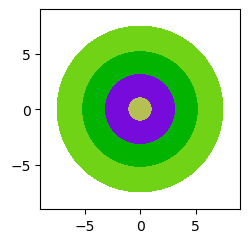

In [24]:
plot_args = {'width':(lattice_pitch,lattice_pitch)}
bundle_universe = openmc.Universe(cells=coolant_cells)
bundle_universe.plot(**plot_args)

In [25]:
coolant.temperature = 973

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
fuel_cell.temperature = 1473

clad_cell_1 = openmc.Cell(fill=clad_in, region=+surf_fuel & -surf_clad_1)
clad_cell_1.temperature = 1273

clad_cell_2 = openmc.Cell(fill=clad_out, region=+surf_clad_1 & -surf_clad_2)
clad_cell_2.temperature = 973

pin_universe = openmc.Universe(cells=(fuel_cell,clad_cell_1,clad_cell_2))

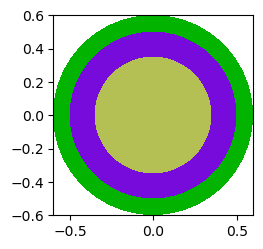

In [26]:
pin_universe.plot(**{'width':(2*r_clad_2,2*r_clad_2)})

In [27]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        theta = (a + j/n*360)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad_2)
        coolant_cells[i].region &= +pin_boundary

        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=100.
  warn(msg, IDWarning)
/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=200.
  warn(msg, IDWarning)
/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=201.
  warn(msg, IDWarning)
/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=202.
  warn(msg, IDWarning)
/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=203.
  warn(msg, IDWarning)
/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=204.
  w

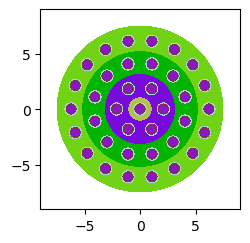

In [28]:
bundle_universe.plot(**plot_args)

In [29]:
lattice_boundary = openmc.model.RectangularParallelepiped(-lattice_pitch/2,lattice_pitch/2,-lattice_pitch/2,lattice_pitch/2,-81.6726,81.6726,boundary_type = 'reflective')

pt=openmc.Cell(fill=clad_in, region= +surf_pt_1 & -surf_pt_2)
pt.temperature = 973

bundle_universe.add_cell(pt)
moderator_cell=openmc.Cell(fill=moderator, region=-lattice_boundary & +surf_pt_2)
moderator_cell.temperature = 973

bundle_universe.add_cell(moderator_cell)

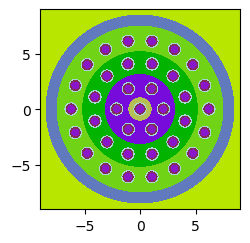

In [30]:
bdu=bundle_universe
bdu.plot(**plot_args)

In [31]:
geometry = openmc.Geometry(bdu)
geometry.export_to_xml()

materials=openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

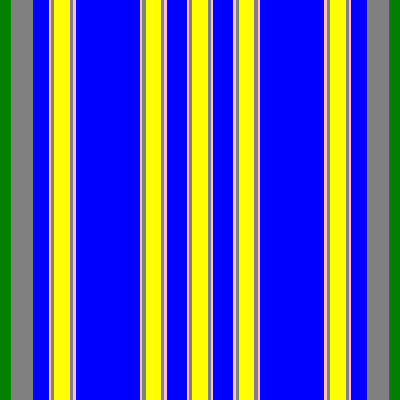

In [39]:
plot = openmc.Plot.from_geometry(geometry)
#plot.basis='xz'
#plot.origin=(0,0,0)
plot.color_by = 'material'
plot.colors = {
    fuel: 'yellow',
    clad_in: 'grey',
    clad_out: 'pink',
    coolant: 'blue',
    moderator: 'green',
}
plot.to_ipython_image()

In [33]:
settings = openmc.Settings()
settings.particles = 100000
settings.batches = 100
settings.inactive = 15
settings.temperature={'method':'interpolation','range':(250, 2500)}
box = openmc.stats.Box(lower_left = (-lattice_pitch/2,-lattice_pitch/2,-H/2),
                      upper_right = (lattice_pitch/2,lattice_pitch/2,H/2),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src
settings.export_to_xml()

In [34]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]

In [35]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [17]:
fuel.volume = pi*r_fuel**2*H*37 #cm^3 for 37 fuel pins

In [18]:
model=openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb80_pwr.xml")

power_density = 35 #MW/kg

days = 3600*24; #number of seconds in a day

time_steps = [0.1*days,0.1*days, 0.1*days, 0.1*days, 0.1*days,
              0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.25*days,
              0.5*days, 0.5*days, 0.5*days,0.5*days,
              0.75*days, 0.75*days, 0.75*days, 0.75*days,
              1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days, 1*days,
              1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days, 1.5*days,
              2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days, 2*days,
              5*days, 5*days, 5*days, 5*days,5*days, 5*days, 5*days, 5*days, 5*days, 5*days,5*days, 5*days,
              10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days, 10*days,
              15*days, 15*days, 15*days, 15*days, 15*days, 15*days, 15*days, 15*days,
              20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days, 20*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days, 30*days,
              40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days, 40*days,
              50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days, 50*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days, 60*days,
              60*days, 60*days, 60*days, 60*days]


cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density = power_density,timestep_units='s')

#repeat_depletion = False;

#if(repeat_depletion):
#    cecm.integrate()

In [19]:
cemc.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg25 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Mg25.h5
 Reading Mg26 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Mg26.h5
 Reading Al26_m1 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Al26_m1.h5
 Reading Al27 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Al27.h5
 Reading Si31 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Si31.h5
 Reading Si32 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Si32.h5
 Reading P31 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/P31.h5
 Reading S32 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S32.h5
 Reading S33 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S33.h5
 Reading S34 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S34.h5
 Reading S35 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S35.h5
 Reading S36 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/S36.h5
 Reading Cl35 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cl35.h5
 Reading Cl36 from /home/m240600/OpenMC_Cros

 Reading Cd114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd114.h5
 Reading Cd115_m1 from
 /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Cd116.h5
 Reading In113 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In113.h5
 Reading In114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In114.h5
 Reading In115 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/In115.h5
 Reading Sn112 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn112.h5
 Reading Sn113 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn113.h5
 Reading Sn114 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn114.h5
 Reading Sn115 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn115.h5
 Reading Sn116 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn116.h5
 Reading Sn117 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn117.h5
 Reading Sn118 from /home/m240600/OpenMC_CrossSections/lib80x_hdf5/Sn118.h5
 Read

In [20]:
results = openmc.deplete.Results("./depletion_results.h5")

In [21]:
time, k =results.get_keff()

In [22]:
time /=(24*3600*1392)/48.72 #converts to MWd/kgHM
time

array([0.0000e+00, 3.5000e-03, 7.0000e-03, 1.0500e-02, 1.4000e-02,
       1.7500e-02, 2.6250e-02, 3.5000e-02, 4.3750e-02, 5.2500e-02,
       6.1250e-02, 7.0000e-02, 8.7500e-02, 1.0500e-01, 1.2250e-01,
       1.4000e-01, 1.6625e-01, 1.9250e-01, 2.1875e-01, 2.4500e-01,
       2.8000e-01, 3.1500e-01, 3.5000e-01, 3.8500e-01, 4.2000e-01,
       4.5500e-01, 4.9000e-01, 5.2500e-01, 5.6000e-01, 5.9500e-01,
       6.3000e-01, 6.6500e-01, 7.0000e-01, 7.3500e-01, 7.7000e-01,
       8.0500e-01, 8.5750e-01, 9.1000e-01, 9.6250e-01, 1.0150e+00,
       1.0675e+00, 1.1200e+00, 1.1725e+00, 1.2250e+00, 1.2775e+00,
       1.3300e+00, 1.4000e+00, 1.4700e+00, 1.5400e+00, 1.6100e+00,
       1.6800e+00, 1.7500e+00, 1.8200e+00, 1.8900e+00, 1.9600e+00,
       2.0300e+00, 2.1000e+00, 2.2750e+00, 2.4500e+00, 2.6250e+00,
       2.8000e+00, 2.9750e+00, 3.1500e+00, 3.3250e+00, 3.5000e+00,
       3.6750e+00, 3.8500e+00, 4.0250e+00, 4.2000e+00, 4.5500e+00,
       4.9000e+00, 5.2500e+00, 5.6000e+00, 5.9500e+00, 6.3000e

In [23]:
k

array([[1.50624192e+00, 7.43515519e-04],
       [1.50693891e+00, 8.55223499e-04],
       [1.50714122e+00, 7.67150925e-04],
       [1.50609939e+00, 7.63864805e-04],
       [1.50564416e+00, 9.10032377e-04],
       [1.50440470e+00, 8.59403552e-04],
       [1.50283616e+00, 7.71601248e-04],
       [1.50169087e+00, 8.78120337e-04],
       [1.49930197e+00, 7.76813422e-04],
       [1.50045693e+00, 9.06368682e-04],
       [1.49906039e+00, 7.92225922e-04],
       [1.49948941e+00, 8.17265563e-04],
       [1.49918745e+00, 9.10533504e-04],
       [1.49795285e+00, 7.63535236e-04],
       [1.49905920e+00, 7.64981195e-04],
       [1.49685653e+00, 7.96104954e-04],
       [1.49843697e+00, 8.17792299e-04],
       [1.49924742e+00, 9.28209865e-04],
       [1.49791728e+00, 7.71872671e-04],
       [1.49824468e+00, 8.39394763e-04],
       [1.49686675e+00, 8.07705618e-04],
       [1.49673133e+00, 8.00988030e-04],
       [1.49637717e+00, 7.59617875e-04],
       [1.49659514e+00, 7.86125941e-04],
       [1.496027

In [47]:
eff=[1]*201

In [50]:
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

z = find_roots(time,eff-k[:,0])
z

array([173.542881])

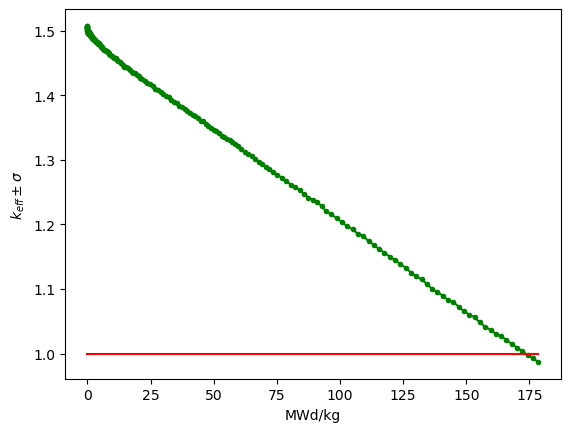

In [39]:
pyplot.plot(time, k[:, 0],color='green',marker='o',markersize=3)
eff=[1]*201
pyplot.plot(time,eff,color='red')
pyplot.xlabel("MWd/kg")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.show()